In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

In [2]:
def polynomial_regression(y, kernel_size, poly=4):
    kernel = np.ones(kernel_size) / kernel_size
    y_reg = np.array(np.arange(len(y))).reshape(-1,1)
    pf = PolynomialFeatures(poly)
    y_reg = pf.fit_transform(y_reg)
    reg_fit = LinearRegression().fit(y_reg, y)
    reg_predict = reg_fit.predict(y_reg)
    signal = y - reg_predict
    signal -= signal.mean()
    smoothed_signal = np.convolve(signal, kernel, mode='same')
    smoothed_signal[:int(kernel_size/2)] = np.nan
    smoothed_signal[len(smoothed_signal)-int(kernel_size/2):] = np.nan
    return smoothed_signal, signal, reg_predict

In [3]:
file_list1 = [file for file in os.listdir(".\\Results\\Infors 2") if file.endswith(".xlsx")]
file_list1 = [".\\Results\\Infors 2\\" + file for file in file_list1]
file_list1

['.\\Results\\Infors 2\\2024-09-10T10_08_backscatter_control_1.xlsx',
 '.\\Results\\Infors 2\\2024-09-10T10_09_21%3A00.xlsx',
 '.\\Results\\Infors 2\\2024-09-10T10_10_00%3A00.xlsx',
 '.\\Results\\Infors 2\\2024-09-10T10_10_03%3A00.xlsx',
 '.\\Results\\Infors 2\\2024-09-10T10_10_06%3A00.xlsx',
 '.\\Results\\Infors 2\\2024-09-10T10_11_09%3A00.xlsx',
 '.\\Results\\Infors 2\\2024-09-10T10_11_12%3A00-1.xlsx',
 '.\\Results\\Infors 2\\2024-09-10T10_12_18%3A00-1.xlsx']

In [4]:
file_list2 = [file for file in os.listdir(".\\Results\\Infors 3") if file.endswith(".xlsx")]
file_list2 = [".\\Results\\Infors 3\\" + file for file in file_list2]
file_list2

['.\\Results\\Infors 3\\2024-09-10T10_14_backscatter_control_2.xlsx',
 '.\\Results\\Infors 3\\2024-09-10T10_15_04%3A30-1.xlsx',
 '.\\Results\\Infors 3\\2024-09-10T10_15_22%3A30-1.xlsx',
 '.\\Results\\Infors 3\\2024-09-10T10_16_10%3A30.xlsx',
 '.\\Results\\Infors 3\\2024-09-10T10_16_13%3A30.xlsx',
 '.\\Results\\Infors 3\\2024-09-10T10_17_16%3A30.xlsx',
 '.\\Results\\Infors 3\\2024-09-10T10_17_19%3A30.xlsx',
 '.\\Results\\Infors 3\\2024-09-10T10_18_21%3A00-II.xlsx']

In [5]:
controls1 = [file for file in file_list1 if re.search(r"backscatter", file)]
controls1

['.\\Results\\Infors 2\\2024-09-10T10_08_backscatter_control_1.xlsx']

In [6]:
controls2 = [file for file in file_list2 if re.search(r"backscatter", file)]
controls2

['.\\Results\\Infors 3\\2024-09-10T10_14_backscatter_control_2.xlsx']

In [7]:
data1 = []
for file in controls1:
    excel = pd.ExcelFile(file)
    backscatter_sheet = "".join([sheet for sheet in excel.sheet_names if re.search(r"backscatter", sheet)])
    data1.append(pd.read_excel(io=file, sheet_name=backscatter_sheet, skiprows=1))

c:\Users\Florian\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
data2 = []
for file in controls2:
    excel = pd.ExcelFile(file)
    backscatter_sheet = "".join([sheet for sheet in excel.sheet_names if re.search(r"backscatter", sheet)])
    data2.append(pd.read_excel(io=file, sheet_name=backscatter_sheet, skiprows=1))

c:\Users\Florian\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
group_A:pd.DataFrame = data1[0].iloc[:, 1:]
group_B:pd.DataFrame = data2[0].iloc[:, 1:]

group_A["Relative Time [s]"] = group_A["Relative Time [s]"] / 3600
group_B["Relative Time [s]"] = group_B["Relative Time [s]"] / 3600

group_A["Value [a.u.]"] = group_A["Value [a.u.]"] - min(group_A["Value [a.u.]"])
group_B["Value [a.u.]"] = group_B["Value [a.u.]"] - min(group_B["Value [a.u.]"])

group_A

,Relative Time [s],Value [a.u.]
0,0.004234,16.99408
1,0.009790,17.94108
2,0.015345,16.40168
3,0.020901,14.00625
4,0.026456,13.90106
...,...,...
16687,95.052483,350.62126
16688,95.059627,350.91791
16689,95.065182,350.56336
16690,95.070738,350.41526


In [10]:
group_A.rename(columns={"Relative Time [s]": "Relative_Time[h]",
                        "Value [a.u.]": "backscatter[a.u.]"}, inplace=True)
group_B.rename(columns={"Relative Time [s]": "Relative_Time[h]",
                        "Value [a.u.]": "backscatter[a.u.]"}, inplace=True)


group_A = group_A[group_A["Relative_Time[h]"] <= 96]
group_B = group_B[group_B["Relative_Time[h]"] <= 96]

group_B

,Relative_Time[h],backscatter[a.u.]
0,0.004363,9.08567
1,0.009918,9.89731
2,0.015474,9.85773
3,0.021029,10.25015
4,0.026585,10.98661
...,...,...
16670,95.075191,453.00395
16671,95.080747,453.60995
16672,95.086302,454.46289
16673,95.091858,455.16295


Text(0.5, 0, 'Time [h]')

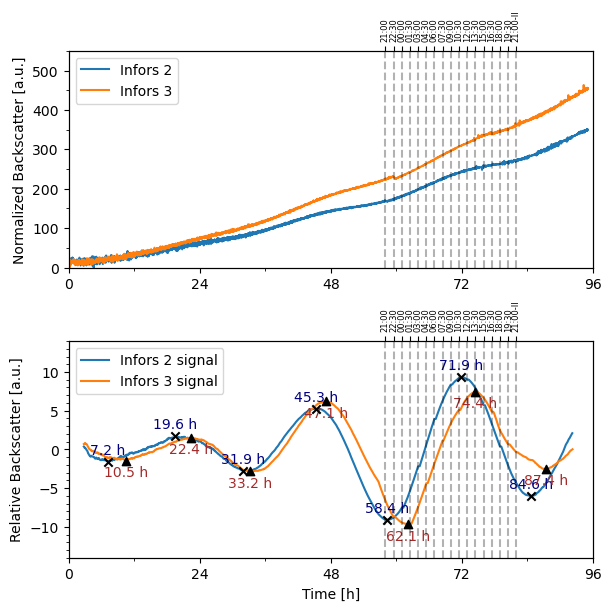

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 6), layout="constrained")

ax[0].plot(group_A["Relative_Time[h]"], group_A["backscatter[a.u.]"], label="Infors 2")
ax[0].plot(group_B["Relative_Time[h]"], group_B["backscatter[a.u.]"], label="Infors 3")

smooth_A, sig_A, reg_A = polynomial_regression(group_A["backscatter[a.u.]"].dropna(), 1000)
smooth_B, sig_B, reg_B = polynomial_regression(group_B["backscatter[a.u.]"].dropna(), 1000)

ax[1].plot(group_A["Relative_Time[h]"].dropna(), smooth_A, zorder=1, label="Infors 2 signal")
ax[1].plot(group_B["Relative_Time[h]"].dropna(), smooth_B, zorder=1, label="Infors 3 signal")

peaks_A = find_peaks(smooth_A, distance=2000, width=100)
troughs_A = find_peaks(smooth_A * -1, distance=2000, width=100)
peaks_B = find_peaks(smooth_B, distance=2000, width=100)
troughs_B = find_peaks(smooth_B * -1, distance=2000, width=100)

extrema_A = np.concatenate([peaks_A[0], troughs_A[0]])
extrema_B = np.concatenate([peaks_B[0], troughs_B[0]])

height_A = smooth_A[extrema_A]
time_A = group_A["Relative_Time[h]"][extrema_A]

height_B = smooth_B[extrema_B]
time_B = group_B["Relative_Time[h]"][extrema_B]

ax[0].set_ylim(0, 550)
ax3: plt.Axes = ax[0].twiny()
ax3.set_xlim(0, 96)
ax3.set_xticks([58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82]) # Zeitpunkte der Probenentnahme!!!!
ax3.set_xticklabels(["21:00", "22:30", "00:00", "01:30", "03:00", "04:30", "06:00", "07:30",
                     "09:00", "10:30", "12:00", "13:30", "15:00", "16:30", "18:00", "19:30", "21:00-II"], rotation=90, fontsize=6)
ax3.vlines([58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82], 0, 550, color="k", alpha=0.3, ls="--", zorder=2)

ax4: plt.Axes = ax[1].twiny()
ax4.set_xlim(0, 96)
ax4.set_xticks([58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82])
ax4.set_xticklabels(["21:00", "22:30", "00:00", "01:30", "03:00", "04:30", "06:00", "07:30",
                     "09:00", "10:30", "12:00", "13:30", "15:00", "16:30", "18:00", "19:30", "21:00-II"], rotation=90, fontsize=6)
ax4.vlines([58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82], -14, 14, color="k", alpha=0.3, ls="--", zorder=2)

ax[1].scatter(time_A, height_A, marker="x", color="k", zorder=2)
ax[1].scatter(time_B, height_B, marker="^", color="k", zorder=2)

for time, height in zip(time_A, height_A):
    ax[1].text(time, height + 0.6, f"{time:.1f} h", ha="center", va="bottom", color="navy", zorder=1)


for time, height in zip(time_B, height_B):
    ax[1].text(time, height - 0.6, f"{time:.1f} h", ha="center", va="top", color="brown", zorder=1)

ax[0].set_xlim(0, 96)
ax[1].set_xlim(0, 96)
ax[1].set_ylim(-14, 14)

ax[0].legend(loc=2)
ax[1].legend(loc=2)

ax[0].set_yticks(range(0, 550, 100))
ax[0].set_yticks(range(0, 551, 50), minor=True)

ax[1].set_yticks(range(-10, 11, 5))
ax[1].set_yticks(range(-14, 15, 1), minor=True)

ax[0].set_xticks(range(0, 97, 24))
ax[0].set_xticks(range(0, 97, 12), minor=True)

ax[1].set_xticks(range(0, 97, 24))
ax[1].set_xticks(range(0, 97, 12), minor=True)


ax[0].set_ylabel("Normalized Backscatter [a.u.]")
ax[1].set_ylabel("Relative Backscatter [a.u.]")

ax[1].set_xlabel("Time [h]")

Text(0.5, 0, 'Time [h]')

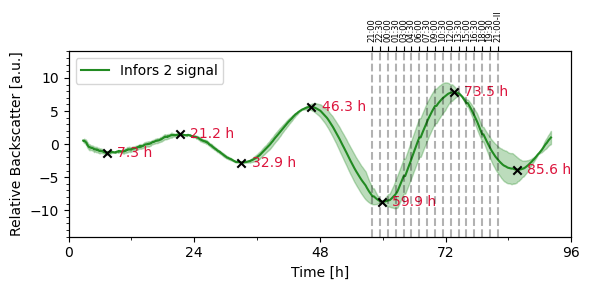

In [12]:
fig, ax = plt.subplots(figsize=(6, 3), layout="tight")

smooth_A, sig_A, reg_A = polynomial_regression(group_A["backscatter[a.u.]"].dropna(), 1000)
smooth_B, sig_B, reg_B = polynomial_regression(group_B["backscatter[a.u.]"].dropna(), 1000)

time = group_A["Relative_Time[h]"]

if len(smooth_A) != len(smooth_B):
    if len(smooth_A) > len(smooth_B):
        smooth_A = smooth_A[:len(smooth_B)]
        time = time[:len(smooth_B)]
    elif len(smooth_A) < len(smooth_B):
        smooth_B = smooth_B[:len(smooth_A)]
        time = time[:len(smooth_A)]

# print(len(smooth_A))
# print(len(smooth_B))

mean = np.mean(np.array([smooth_A, smooth_B]), axis=0)



ax.plot(time, mean, zorder=1, label="Infors 2 signal", color="forestgreen")
ax.fill_between(time, smooth_A, smooth_B, color="forestgreen", alpha=0.3)

peaks = find_peaks(mean, distance=2000, width=100)
troughs = find_peaks(mean * -1, distance=2000, width=100)

extrema = np.concatenate([peaks[0], troughs[0]])

height = mean[extrema]
time = time[extrema]


ax2: plt.Axes = ax.twiny()
ax2.set_xlim(0, 96)
ax2.set_xticks([58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82])
ax2.set_xticklabels(["21:00", "22:30", "00:00", "01:30", "03:00", "04:30", "06:00", "07:30",
                     "09:00", "10:30", "12:00", "13:30", "15:00", "16:30", "18:00", "19:30", "21:00-II"], rotation=90, fontsize=6)
ax2.vlines([58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82], -14, 14, color="k", alpha=0.3, ls="--", zorder=2)

ax.scatter(time, height, marker="x", color="k", zorder=2)

for time, height in zip(time, height):
    ax.text(time + 2, height, f"{time:.1f} h", ha="left", va="center", color="crimson", zorder=1)


ax.set_xlim(0, 96)
ax.set_ylim(-14, 14)

ax.legend(loc=2)

ax.set_yticks(range(-10, 11, 5))
ax.set_yticks(range(-14, 15, 1), minor=True)

ax.set_xticks(range(0, 97, 24))
ax.set_xticks(range(0, 97, 12), minor=True)

ax.set_ylabel("Relative Backscatter [a.u.]")

ax.set_xlabel("Time [h]")

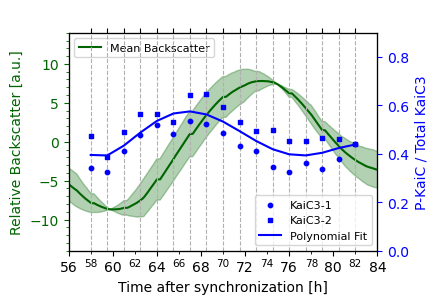

In [23]:
cm_in_inches = 1/2.54

# 11.4 cm width:
fig, ax = plt.subplots(figsize=(11.4*cm_in_inches, 8*cm_in_inches), layout="tight")

# 8.7 cm width:
# fig, ax = plt.subplots(figsize=(8.7*cm_in_inches, 8*cm_in_inches), layout="tight")

smooth_A, sig_A, reg_A = polynomial_regression(group_A["backscatter[a.u.]"].dropna(), 1000)
smooth_B, sig_B, reg_B = polynomial_regression(group_B["backscatter[a.u.]"].dropna(), 1000)

time = group_A["Relative_Time[h]"]

if len(smooth_A) != len(smooth_B):
    if len(smooth_A) > len(smooth_B):
        smooth_A = smooth_A[:len(smooth_B)]
        time = time[:len(smooth_B)]
    elif len(smooth_A) < len(smooth_B):
        smooth_B = smooth_B[:len(smooth_A)]
        time = time[:len(smooth_A)]

# print(len(smooth_A))
# print(len(smooth_B))

mean = np.mean(np.array([smooth_A, smooth_B]), axis=0)



ax.plot(time, mean, zorder=1, color="darkgreen", label="Mean Backscatter") # , label="BSC signal"
ax.fill_between(time, smooth_A, smooth_B, color="darkgreen", alpha=0.3, zorder=1)

peaks = find_peaks(mean, distance=2000, width=100)
troughs = find_peaks(mean * -1, distance=2000, width=100)

extrema = np.concatenate([peaks[0], troughs[0]])

height = mean[extrema]
time = time[extrema]

xticks2 = [58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82]
ax2: plt.Axes = ax.twiny()
ax2.grid(axis="x", ls="--", zorder=0)
ax2.set_xlim(56, 84)
ax2.set_xticks(xticks2)
# xticklabels2 = [f"{tick-46.3:.1f}" for tick in xticks2]
# ax2.set_xticklabels(xticklabels2, rotation=60, fontsize=8)
ax2.tick_params(labelcolor="w")
# ax2.vlines([58, 59.5, 61, 62.5, 64, 65.5, 67, 68.5, 70, 71.5, 73, 74.5, 76, 77.5, 79, 80.5, 82], -14, 14, color="k", alpha=0.3, ls="--", zorder=2)


# ax.scatter(time, height, marker="x", color="k", zorder=2)

# for time, height in zip(time, height):
#     if time >= 56:
#         if time <= 84:
#             ax.text(time + 2, height, f"{time:.1f} h", ha="left", va="center", color="crimson", zorder=1)

ax3 = plt.twinx(ax)

protein_data = pd.read_excel(".\\Protein\\20241024_sampling_20240909_summary_KaiC1+KaiC3.xlsx", skiprows=range(8))

def protein_plot(ax:plt.Axes, data:pd.Series, time:list):

    def poly4(x, a, b, c, d, e):
        return a*x**4 + b*x**3 + c*x**2 + d*x + e
    
    def poly5(x, a, b, c, d, e, f):
        return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f
    
    KaiC3_1 = data["P-KaiC3-1.1"]
    KaiC3_2 = data["P-KaiC3-1.2"]
    mean = np.mean([KaiC3_1, KaiC3_2], axis=0)

    fit = np.polyfit(time, mean, deg=5)
    # print(np.max(poly5(np.array(time), *fit)))

    # ax.plot(time, mean, ls="-", color="b", label="KaiC3 mean") # , label="KaiC3 mean"
    ax.scatter(time, KaiC3_1, color="b", label="KaiC3-1", marker="o", s=10)
    ax.scatter(time, KaiC3_2, color="b", label="KaiC3-2", marker="s", s=10)

    ax.plot(time, poly5(np.array(time), *fit), color="b", label="Polynomial Fit")

protein_plot(ax3, protein_data, xticks2)



# ax3.plot(xticks2, protein_data["P-KaiC1-1.1"], color="crimson")
# ax3.scatter(xticks2, protein_data["P-KaiC1-1.1"], color="crimson", marker="^", s=10, label="KaiC1")

ax3.set_xlim((-0.3, 24.3))
ax3.set_xticks(np.arange(0, 25, 1.5))
ax3.set_xticklabels(np.arange(0, 25, 1.5), rotation=35)
ax3.set_xlabel("Sample Timepoints [h]")
ax3.set_ylabel("P-KaiC / Total KaiC3", color="b")
ax3.set_ylim((0,0.9))
ax3.tick_params(axis="y", colors="b", labelcolor="b")
# ax3.tick_params(axis='y', colors='b')

ax.set_xlim(56, 84)
ax.set_ylim(-14, 14)



ax.set_yticks(range(-10, 11, 5))
ax.set_yticks(range(-14, 15, 1), minor=True)
ax.tick_params(axis='y', colors='darkgreen', which="both")

ax.set_xticks(range(56, 85, 4))
ax.set_xticks(range(56, 85, 2), minor=True)

# for 11.4 cm width:
ax.set_xticklabels(range(56, 85, 4), minor=False, size=10)
ax.set_xticklabels(range(56, 85, 2), minor=True, fontsize=7.5)

ax.legend(loc="upper left", fontsize=8).set_zorder(1)
ax3.legend(loc="lower right", fontsize=8, ncol=1) # , bbox_to_anchor=(0.12, 0.78)

# for 8.7 cm width:
# ax.set_xticklabels(range(56, 85, 4), minor=False, size=8)
# ax.set_xticklabels(range(56, 85, 2), minor=True, fontsize=6)
# ax3.legend(loc="lower right", fontsize=8, ncol=1)

ax.set_ylabel("Relative Backscatter [a.u.]", color="darkgreen")

ax.set_xlabel("Time after synchronization [h]")
# ax2.set_xlabel("Time from last peak [h]")


fig.savefig(".\\plots\\protein_oscillation_11,4x8.png", dpi=500)